# Radio Recievers and HI Detection

In [10]:
from matplotlib import pyplot as plt
import csv
import numpy as np
from astropy import units as u
import matplotlib
from astropy import constants as apyconst
from IPython.display import Image
matplotlib.rcParams['figure.figsize'] = [12, 8]

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme="onedork",grid=False, figsize=[10,6])
#jtplot.reset()
matplotlib.rcParams['figure.figsize'] = [8, 4]
%matplotlib notebook

# Data Analysis

## Day1 Galactic Test Data 

<IPython.core.display.Javascript object>


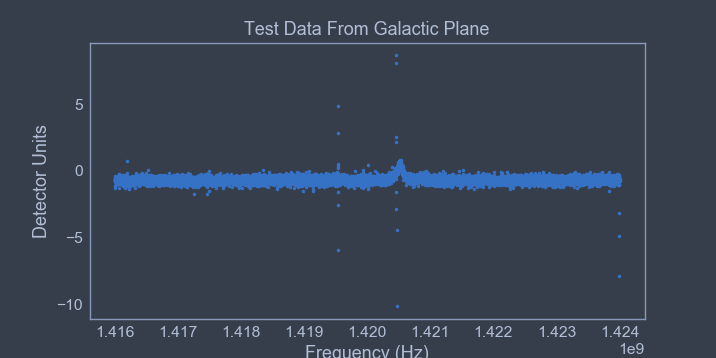

Text(0.5, 1.0, 'Test Data From Galactic Plane')

In [12]:
def get_data(path, clean = True):
    alt = np.loadtxt(path,delimiter=',')
    if clean:
        alt_off = np.loadtxt('5min_off_altair.csv', delimiter=',')
        alt[::,1] = alt[::,1] - alt_off[::,1]
    return alt

data = get_data('5min_altair.csv')

plt.figure("data_test")
plt.plot(data[::,0],data[::,1],'.')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Detector Units")
plt.title("Test Data From Galactic Plane")

## Vector Analyzer Data

In [12]:
s = np.loadtxt('vector_analyzer/S.csv',delimiter=',', skiprows=18)
s2 = np.loadtxt('vector_analyzer/S2.csv',delimiter=',',skiprows=18)
bp = np.loadtxt('vector_analyzer/2BP.csv',delimiter=',',skiprows=18)
lbp  = np.loadtxt('vector_analyzer/LBP.csv',delimiter=',',skiprows=18)
sbp  = np.loadtxt('vector_analyzer/SBP.csv',delimiter=',',skiprows=18)

<IPython.core.display.Javascript object>


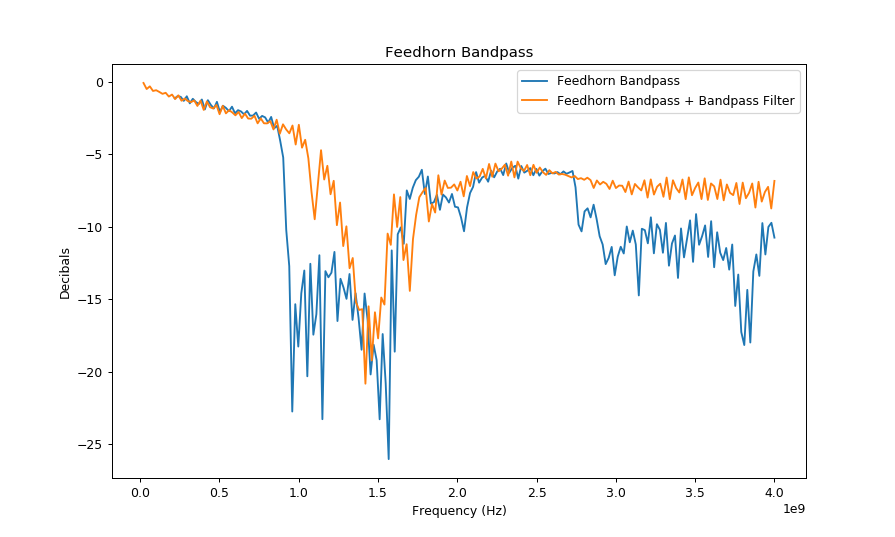

In [13]:
plt.figure("Vector")
plt.plot(s[::,0],s[::,1], label = "Feedhorn Bandpass")
plt.plot(bp[::,0],bp[::,1], label = "Feedhorn Bandpass + Bandpass Filter")
plt.title('Feedhorn Bandpass')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decibals")
plt.legend()

## Smoothen the data 

In [18]:
np.median(y)

NameError: name 'y' is not defined

In [19]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
peaks, _ = find_peaks(y, height = 0)
yhat = savgol_filter(y, 109, 3)
peaks, dic = find_peaks(yhat, height = 0)

NameError: name 'y' is not defined

/home/shaaban/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


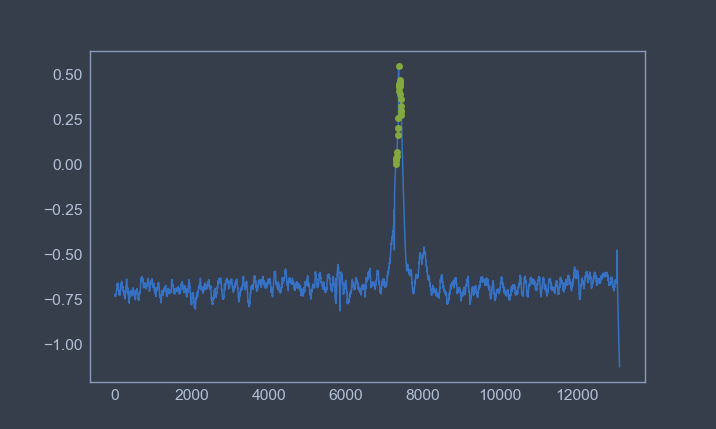

In [141]:
yhat = savgol_filter(y, 109, 3)
plt.figure()
#plt.plot(y)
plt.plot(yhat)
plt.plot(peaks, yhat[peaks], "o")

/home/shaaban/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


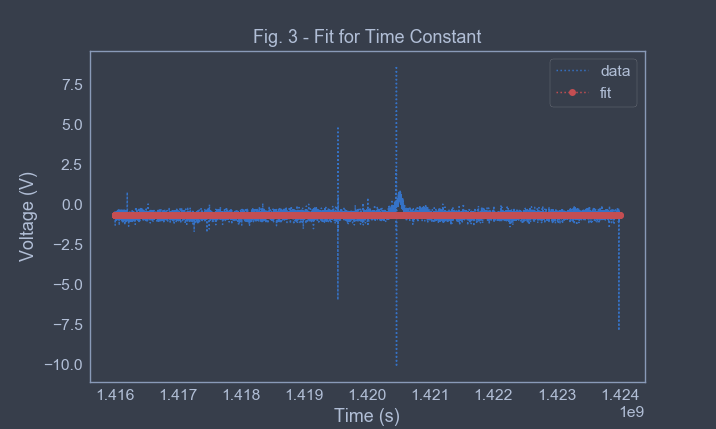

Text(0, 0.5, 'Voltage (V)')

In [58]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = data[::,0]
y = data[::,1]
n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.figure()
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

# mean

In [8]:
sun_0 = np.loadtxt("sun_0.csv", delimiter=",")
sun_1 = np.loadtxt("sun_1.csv", delimiter=",")
sun_2 = np.loadtxt("sun_2.csv", delimiter=",")
sun_3 = np.loadtxt("sun_3.csv", delimiter=",")

In [2]:
ls

5min_altair.csv      gal1_zoom.png                 sun_0.csv  sun_4.csv
5min_off_altair.csv  horn.png                      sun_1.csv  vector_analyzer/
Analysis.ipynb       Lab3_AST2050_2019_Winter.pdf  sun_2.csv  vector.png
gal1_onoff.png       locations.xlsx                sun_3.csv


<IPython.core.display.Javascript object>


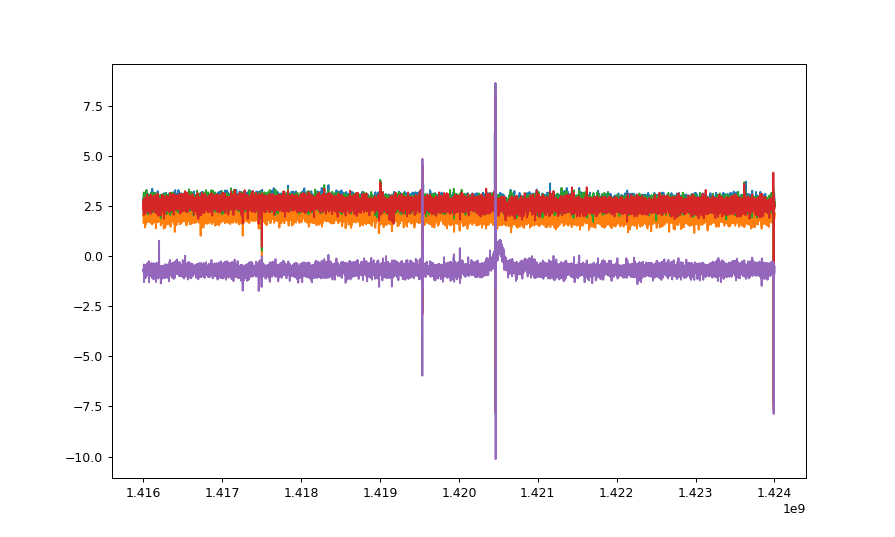

In [22]:
plt.figure("sun")
plt.plot(sun_0[::,0],sun_0[::,1] -alt_off[::,1])
plt.plot(sun_1[::,0],sun_1[::,1]  -alt_off[::,1])
plt.plot(sun_2[::,0],sun_2[::,1] -alt_off[::,1])
plt.plot(sun_3[::,0],sun_3[::,1] -alt_off[::,1])
plt.plot(data[::,0],data[::,1])

In [15]:
alt_off = np.loadtxt('5min_off_altair.csv', delimiter=',')

<IPython.core.display.Javascript object>


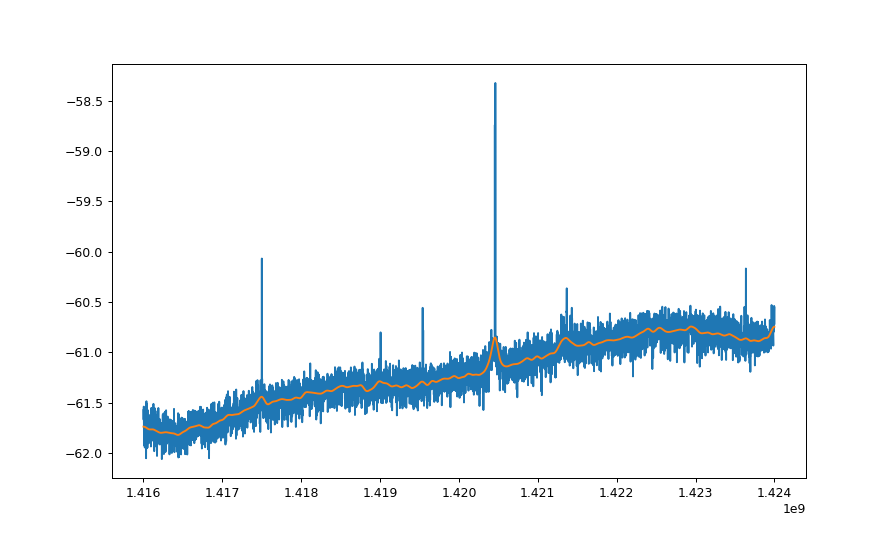

In [42]:
from scipy.ndimage import gaussian_filter
plt.figure()
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],50))